In [25]:
# check GPU
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [26]:
# pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# checkout specific branch if needed
!cd mode_connectivity; git checkout geodesics

In [1]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

sys.path.append("mode_connectivity") # run for colab

In [2]:
# !pip install torch
# !pip install tqdm


In [5]:
import torch
from torchvision import transforms, datasets
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils
from mode_connectivity.training_config import *
from mode_connectivity.lmc import *
from mode_connectivity.training import *

from mode_connectivity.models.mlp import MLP

from google.colab import files

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Training MLP models

In [32]:
# training_config = MLP_MNIST_DEFAULT
# training_config.epochs = 5
# training_config.seed = 7

# # train model a
# # model_a_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
# model_a = train_model(*setup_train(training_config), verbose = 1)
# torch.save(model_a.state_dict(), 'mlp_mnist_model_a.pt')

# # change seed to get different model
# training_config.seed = 42

# # train model b
# # model_b_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
# model_b = train_model(*setup_train(training_config), verbose = 1)
# torch.save(model_b.state_dict(), 'mlp_mnist_model_b.pt')  

In [33]:
# # call this on googl colab to download files to local repo
# files.download('model_a_noisy_0.1.pt')
# files.download('model_b_noisy_0.1.pt')

# LMC in param space

In [34]:
# n_points = 25
# (
#     permuted_params,
#     train_acc_naive,
#     test_acc_naive,
#     train_acc_perm,
#     test_acc_perm,
# ) = linear_mode_connect(
#     MLP, "mlp_mnist_model_a.pt", "mlp_mnist_model_b.pt", "mnist", n_points=n_points, verbose=1
# )
# torch.save(permuted_params, 'mlp_mnist_model_pb.pt') 
# # files.download('mlp_mnist_model_pb.pt') 

In [35]:
# # First we do the basic linear interpolation plot
# lambdas = torch.linspace(0, 1, steps=n_points)
# plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

# Geodesic MC in functional space

In [7]:
from mode_connectivity.geodesic_opt import optimise_for_geodesic, metric_path_length
from mode_connectivity.utils import metrics
from mode_connectivity.utils import objectives

In [8]:
device, device_kwargs = get_device()
print(device, device_kwargs)

In [10]:
# from torch.utils.data import DataLoader, ConcatDataset

# mnist_dataset = ConcatDataset([trainset, testset])
# all_mnist_dl = DataLoader(dataset = mnist_dataset, batch_size=mnist_dataset.__len__())
# all_mnist_images, all_mnist_lables = next(iter(all_mnist_dl))]
# all_mnist_images = all_mnist_images.to(device)
# print(all_mnist_images.shape,all_mnist_images.device)

In [11]:
# load in model state_dicts
# model_file_path = 'mode_connectivity/model_files/' # use this path in colab
model_file_path = '../model_files/' 

weights_a = torch.load(model_file_path + "mlp_mnist_model_a.pt", map_location=device)
weights_b = torch.load(model_file_path + "mlp_mnist_model_b.pt", map_location=device)
weights_pb = torch.load(model_file_path + "mlp_mnist_model_pb.pt", map_location=device)

In [12]:
train_bs = 512
test_bs = 512

train_loader, test_loader = data.get_data_loaders(
    dataset="mnist", train_kwargs={"batch_size":train_bs}, test_kwargs={"batch_size":test_bs}
)

In [22]:
n_points = 20
loss_fn = metrics.JSD_loss # or metrics.KL_loss
objective_fn = objectives.full_params # or objectives.heuristic_triplets
max_iter = 100
lr = 0.01

opt_weights, losses, sq_euclid_dists = optimise_for_geodesic(
        MLP, weights_a, weights_b,         
        n = n_points,
        loss_metric = loss_fn,
        objective_function = objective_fn,
        dataloader = train_loader,           # train_loader (can add noise to loader via AddGaussianNoise)
        max_iterations = max_iter,          
        learning_rate = lr,
        return_losses = True,                # track path action via loss_metric
        return_euclid_dist= True,            # track path action via euclidean distance
    )

Optimising geodesic ...


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


In [27]:
# save losses and euclid dists for plotting

loss_plots = [loss.detach().cpu() for loss in losses]
sq_euclid_dist_plots = [euclid_dist.detach().cpu() for euclid_dist in sq_euclid_dists]

In [29]:
# save files + download from google colab
# change the header as needed (manual changes for model, data, loss_metric, and objective function)
file_header = "mlp_mnist_bs{}_lr{}_iter{}_n{}_JSDloss_fullparams".format(train_bs, lr, max_iter, n_points)

torch.save(losses, file_header + '_losses.pt')
torch.save(sq_euclid_dists, file_header + '_euclidaction.pt')
torch.save(opt_weights, file_header + '_geodweights.pt')

files.download(file_header + '_losses.pt')
files.download(file_header + '_euclidaction.pt')
files.download(file_header + '_geodweights.pt')


NameError: name 'files' is not defined

NameError: name 'files' is not defined

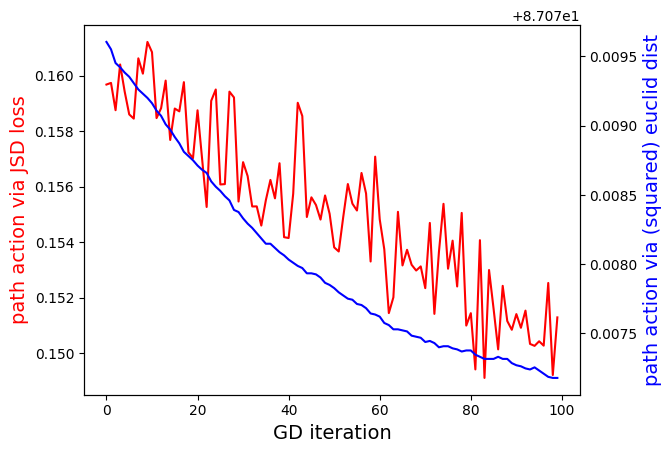

In [30]:
fig, ax = plt.subplots()

loss_type = 'JSD loss'

ax.plot(loss_plots, color = 'red')
ax.set_xlabel('GD iteration', fontsize = 14)
ax.set_ylabel('path action via ' + loss_type, color = 'red', fontsize = 14)

ax2=ax.twinx()
ax2.plot(sq_euclid_dist_plots, color = 'blue')
ax2.set_ylabel('path action via (squared) euclid dist', color = 'blue', fontsize = 14)

# Save png

plt.savefig(file_header + '.png')
files.download(file_header + '.png')

# Add Gaussian Noise to Training data when running geodesic code

In [ ]:
# maybe change the get_data_loaders function